# Replicating [Simple Black-box Adversarial Attacks](https://arxiv.org/pdf/1905.07121.pdf)

This notebook uses the replicate of the Simple Black-box Adversarial attack proposed by Guo et al. [More explanation]

In [ ]:
# necessary imports
# pylint: disable-msg=C0114,C0413,E0401,W0621,W0511

import matplotlib.pyplot as plt
import numpy as np
import random
import torch
from torchvision import transforms

from imagenet.imagenet import ImageNetDataSet
from simple_blackbox_attack.cartesian_set import CartesianSearchVectors
from simple_blackbox_attack.dct_set import DCTSearchVectors
from simple_blackbox_attack.simba.simba import simba
from simple_blackbox_attack.simba.figure1 import simba_best_epsilon

Folder of the ImageNet ILSVRC2012 validation dataset, its labels in the meta data. Note: After accessing [login-access to the ImagNet website](https://image-net.org/signup.php), go to the [ImageNet 2012 version](https://image-net.org/challenges/LSVRC/2012/2012-downloads.php) and download
* Development kit (Task 1 & 2). 2.5MB. - containing the labels and the meta data
* Validation images (all tasks). 6.3GB. - the validation images

Extract both and assign the locations of the folder and files to the corresponding Constants:

In [ ]:
IMAGE_FOLDER = "../../../shared/data/imagenet/val"
LABEL_FILE = "../../../shared/data/imagenet/ILSVRC2012_devkit_t12/data/ILSVRC2012_validation_ground_truth.txt"
META_FILE = "../../../shared/data/imagenet/ILSVRC2012_devkit_t12/data/meta.mat"

Let's get the data.

In [ ]:
preprocess = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
dataset = ImageNetDataSet(image_root=IMAGE_FOLDER, label_file=LABEL_FILE, meta_file=META_FILE, transform=preprocess)

And let's see if everything worked out as expected.

In [ ]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(dataset.meta.loc[label, "label_str"])
    plt.axis("off")
    plt.imshow(img.squeeze().permute(1, 2, 0))
plt.show()

## Classifying with pre-trained ResNet50

Let's use gpu, if available:

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

In [ ]:
model = torch.hub.load("pytorch/vision:v0.10.0", "resnet18", pretrained=True).to(DEVICE)
model.eval()

for _ in range(16):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[sample_idx]
    img = img.to(DEVICE)
    with torch.no_grad():
        logits = model(img.unsqueeze(0))
    probabilities = torch.nn.functional.softmax(logits[0], dim=0)
    probs, predictions = torch.topk(probabilities, 3)
    print(f"The actual label is {int(label)}")
    print(f"the model thinks it is {predictions} with probability {probs}")
    if int(label) == predictions[0] and probs[0] > 0.9:
        print("Correct prediction! And high confidence! Proceeding with this image.")
        image = img
        break

# Adversarial Attack

Let's define the L2-budget we allow the attack.

In [ ]:
BUDGET = 8.0

Let's define a simple basis.

In [ ]:
basis = CartesianSearchVectors(image.size())

And find pertubation for the example image.

In [ ]:
_, pertubation, steps, queries, _ = simba(
    model, image, int(label), basis, step_size=BUDGET / 50, budget=BUDGET
)
logits = model((image + pertubation).unsqueeze(0))
probabilities = torch.nn.functional.softmax(logits[0], dim=0)
probability, prediction = torch.topk(probabilities, 1)

Let's plot the result.

In [ ]:
figure = plt.figure(figsize=(10, 6))
figure.add_subplot(1, 3, 1)
plt.title(f"Original\n{dataset.meta.loc[label, 'label_str']} - {probs[0]*100:.2f}%")
plt.axis("off")
plt.imshow(img.squeeze().permute(1, 2, 0).cpu())
figure.add_subplot(1, 3, 2)
plt.title(f"Perturbation\n{steps} steps")
plt.axis("off")
plt.imshow((pertubation).squeeze().permute(1, 2, 0).cpu())
figure.add_subplot(1, 3, 3)
plt.title(f"Image+Perturbation ({probabilities[int(label)]*100:.2f}%)\n{queries} queries")
plt.axis("off")
plt.imshow((image + pertubation).squeeze().permute(1, 2, 0).cpu())
plt.show()

## DCT Basis

In [ ]:
basis = DCTSearchVectors(image.size(), 1 / 8)
_, pertubation, steps, queries, _ = simba(
    model, image, int(label), basis, step_size=BUDGET / 50, budget=BUDGET
)
logits = model((image + pertubation).unsqueeze(0))
probabilities = torch.nn.functional.softmax(logits[0], dim=0)
probability, prediction = torch.topk(probabilities, 1)

Let's plot the results.

In [ ]:
figure = plt.figure(figsize=(10, 6))
figure.add_subplot(1, 3, 1)
plt.title(f"Original\n{dataset.meta.loc[label, 'label_str']} - {probs[0]*100:.2f}%")
plt.axis("off")
plt.imshow(img.squeeze().permute(1, 2, 0).cpu())
figure.add_subplot(1, 3, 2)
plt.title(f"Perturbation\n{steps} steps")
plt.axis("off")
plt.imshow((pertubation).squeeze().permute(1, 2, 0).cpu())
figure.add_subplot(1, 3, 3)
plt.title(f"Image+Perturbation ({probabilities[int(label)]*100:.2f}%)\n{queries} queries")
plt.axis("off")
plt.imshow((image + pertubation).squeeze().permute(1, 2, 0).cpu())
plt.show()

# Replicating results

Let's sample 1000 images from ImageNet which are classified correctly.

In [ ]:
indices = []
while len(indices) < 1000:
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[sample_idx]
    img = img.to(DEVICE)
    with torch.no_grad():
        logits = model(img.unsqueeze(0))
    probabilities = torch.nn.functional.softmax(logits[0], dim=0)
    probs, predictions = torch.topk(probabilities, 1)
    if int(label) == predictions[0]:
        indices.append(sample_idx)

## Figure 2

_Comparison of success rate and average L2-norm versus number of model queries for untargeted (left) and targeted (right) attacks._

In [24]:
number_images = 8

query_resolution = 2048
success_rate = np.zeros((number_images, query_resolution))
l2_norms = np.zeros((number_images, int(20000 / 64)))
success_rate_dct = np.zeros((number_images, query_resolution))
l2_norms_dct = np.zeros((number_images, int(20000 / 64)))

for i in range(number_images):
    print(i)
    index = random.choice(indices)
    img, label = dataset[index]
    img = img.to(DEVICE)
    
    base = CartesianSearchVectors(img.size())
    base_dct = DCTSearchVectors(img.size(), 1/8)

    was_successful, _, _, queries, l2_norm = simba(model, img, int(label), base, 0.2, 200)
    if was_successful:
        print("cart successful")
        success_rate[i, int(queries / (20000 / query_resolution)) :] = 1
        l2_norms[i, :] = np.pad(
            np.array(l2_norm),
            pad_width=(0, l2_norms.shape[1] - len(l2_norm)),
            mode="edge",
        ) 
    was_successful_dct, pertubation, _, queries_dct, l2_norm_dct = simba(model, img, int(label), base_dct, 0.2, 200)
    while len(base_dct.frequency_dimensions) == 0: # not pretty but with current structure only this way possible
        base_dct = DCTSearchVectors(img.size(), 1/32)
        was_successful_dct, tmp_p, _, tmp_q, tmp_l2 = simba(model, img + pertubation, int(label), base_dct, 0.2, 1e10)
        pertubation += tmp_p
        queries_dct += tmp_q
        l2_norm_dct += tmp_l2
    if was_successful_dct:
        print("dct successful")
        success_rate_dct[i, int(queries_dct / (20000 / query_resolution)) :] = 1
        l2_norms_dct[i, :] = np.pad(
            np.array(l2_norm_dct),
            pad_width=(0, l2_norms_dct.shape[1] - len(l2_norm_dct)),
            mode="edge",
        )

0
0: Label probability 0.9885 - queries 2
512: Label probability 0.9375 - queries 1391
1024: Label probability 0.6812 - queries 2815
cart successful
0: Label probability 0.9885 - queries 6
512: Label probability 0.7425 - queries 1225
dct successful
1
0: Label probability 0.9991 - queries 1
512: Label probability 0.9979 - queries 1340
1024: Label probability 0.9953 - queries 2615
1536: Label probability 0.9900 - queries 3923
2048: Label probability 0.9797 - queries 5287
2560: Label probability 0.9571 - queries 6635
3072: Label probability 0.9163 - queries 7977
3584: Label probability 0.8468 - queries 9349
4096: Label probability 0.7304 - queries 10733
4608: Label probability 0.5713 - queries 12065
5120: Label probability 0.3876 - queries 13454
cart successful
0: Label probability 0.9991 - queries 1
512: Label probability 0.9931 - queries 1210
1024: Label probability 0.9565 - queries 2549
1536: Label probability 0.7951 - queries 3933
Evaluated all vectors
0: Label probability 0.6341 - qu

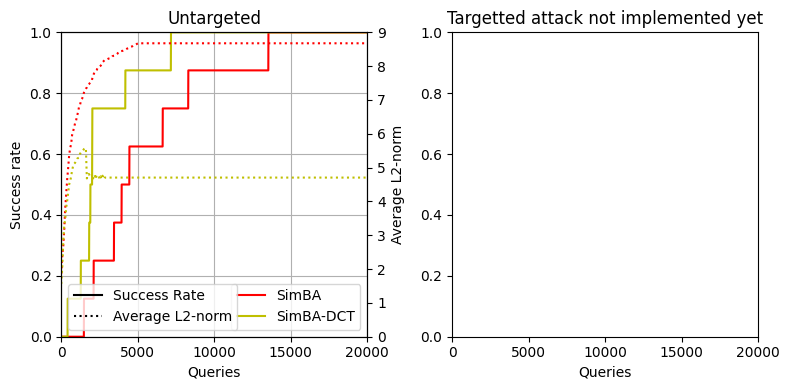

In [25]:
figure = plt.figure(figsize=(8, 4))
ax = figure.add_subplot(1, 2, 1)
ax.grid("on")
ax.plot(np.linspace(0, 20000, query_resolution), success_rate.sum(axis=0) / number_images, color="r", label="SimBA")
ax.plot(np.linspace(0, 20000, query_resolution), success_rate_dct.sum(axis=0) / number_images, color="y", label="SimBA-DCT")
plt.title("Untargeted")
plt.xlabel("Queries")
plt.xlim([0, 20000])
plt.ylabel("Success rate")
ax.set(ylim=[0, 1])

ax.legend(loc='lower right')

ax2 = ax.twinx()
ax2.spines["right"].set_position(("axes", 1.0))

ax2.set(ylim=[0, 9])
ax2.plot(np.linspace(0, 20000, int(20000/64)), l2_norms[l2_norms.sum(axis=1) != 0].mean(axis=0), color="r", linestyle=":")
ax2.plot(np.linspace(0, 20000, int(20000/64)), l2_norms_dct[l2_norms_dct.sum(axis=1) != 0].mean(axis=0), color="y", linestyle=":")
ax2.plot(0, 0, color="k", label="Success Rate")
ax2.plot(0, 0, color="k", label="Average L2-norm", linestyle=":")
plt.ylabel("Average L2-norm")

ax2.legend()

ax = figure.add_subplot(1, 2, 2)
plt.title("Targetted attack not implemented yet")
plt.xlabel("Queries")
plt.xlim([0, 20000])
plt.tight_layout()
plt.show()